In [2]:
# cross_subject_train.py
import numpy as np
import os
#from Utils.utilities import *
from Utils.utilities_Cross_NoVal import *
import h5py
from scipy.stats import zscore
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
set_seed(42) 

In [4]:
class CNN2D_LSTM_Net(nn.Module):
    """
    A hybrid deep learning model for MEG classification.

    Architecture:
    1. 2D CNN layers: Learn local spatiotemporal features from MEG sensor data.
    2. LSTM layer: Captures global temporal dependencies across time.
    3. Fully connected layers: Map learned features to class probabilities.
    """

    def __init__(self, num_classes=4, input_sensors=248, input_time_steps=2227,
                 lstm_hidden_size=64, num_lstm_layers=2, dropout=0.4):
        super(CNN2D_LSTM_Net, self).__init__()

        self.input_sensors = input_sensors
        self.input_time_steps = input_time_steps

        # === Step 1: 2D CNN over (sensors x time) ===
        # This block extracts local patterns in both space (sensor layout) and time.
        self.cnn = nn.Sequential(
            # Conv Layer 1: kernel, stride reduces resolution
            nn.Conv2d(1, 16, kernel_size=(4, 11), stride=(1, 2), padding=(1, 5)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 3)),  
            nn.Dropout2d(dropout),

            # Conv Layer 2
            nn.Conv2d(16, 32, kernel_size=(3, 7), stride=(1, 2), padding=(1, 3)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),  
            nn.Dropout2d(dropout)
        )

        # === Auto-calculate CNN output size for LSTM ===
        # Forward a dummy input to determine the dimensions of the CNN output
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, input_sensors, input_time_steps)
            cnn_out = self.cnn(dummy_input)
            _, cnn_channels, reduced_sensors, reduced_time = cnn_out.shape

            # The LSTM will receive one feature vector per time step,
            # with size = channels × reduced spatial dimension
            self.lstm_input_size = cnn_channels * reduced_sensors
            self.sequence_length = reduced_time

        # === Step 2: LSTM to model temporal dynamics ===
        # Bidirectional LSTM captures temporal dependencies in both directions
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=lstm_hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0,
            bidirectional=False
        )

        # === Step 3: Classifier (fully connected layers) ===
        # Maps LSTM output to final class scores
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_size, lstm_hidden_size//2),  # bidirectional = 2×hidden
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden_size//2, num_classes)
        )

        # === Print model summary ===
        print(f"2D CNN + LSTM Net initialized:")
        print(f"  - LSTM input size: {self.lstm_input_size}")
        print(f"  - Sequence length: {self.sequence_length}")
        print(f"  - Parameters: {sum(p.numel() for p in self.parameters()):,}")

    def forward(self, x):
        """
        x shape: (B, 1, sensors, time_steps)
        """
        batch_size = x.size(0)

        # === Step 1: 2D CNN ===
        x = self.cnn(x)  # Output shape: (B, channels, reduced_sensors, reduced_time)

        # === Step 2: Prepare for LSTM ===
        # Permute and flatten spatial dimensions: (B, time, features)
        x = x.permute(0, 3, 1, 2)  # -> (B, reduced_time, channels, reduced_sensors)
        x = x.contiguous().view(batch_size, self.sequence_length, -1)

        # === Step 3: LSTM ===
        lstm_out, _ = self.lstm(x)  # -> (B, time, 2 * hidden_size)

        # === Step 4: Classification using final time step ===
        x = lstm_out[:, -1, :]  # Extract features from the last time step

        return self.classifier(x)  # -> (B, num_classes)

In [5]:
# Use os.path.join() to create the correct file path
filepath = get_filepath()
print(f"Base filepath: {filepath}")

Base filepath: c:\Users\marcd\Desktop\Master\Courses\Deep_Learning\Project_2\Final Project data\Final Project data


In [6]:
# Use the same label mapping and model architecture as main.py
LABEL_MAP = {
    'rest': 0,
    'task_motor': 1, 
    'task_story': 2,
    'task_working': 3
}

In [ ]:
CONFIG = {
    # Model hyperparameters
    "num_classes": len(LABEL_MAP),
    "input_sensors": 248,
    "input_time_steps": 8906,
    "lstm_hidden_size": 32,
    "num_lstm_layers": 1, #1 or 2
    "dropout": 0.3,
    "file_batch_size": 8,  # Batch size for file loading
    "dataloader_batch_size": 4,  # Batch size for DataLoader
    "downsample_factor": 4,  # Downsample factor for time steps
    
    # Training hyperparameters
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "patience": 12,
    "epochs": 45,
    "seed": 42,
    
}


In [8]:
CNN2D_LSTM_Net_fn = lambda: CNN2D_LSTM_Net(
    num_classes=CONFIG["num_classes"],
    input_sensors=CONFIG["input_sensors"],
    input_time_steps=CONFIG["input_time_steps"],
    lstm_hidden_size=CONFIG["lstm_hidden_size"],
    num_lstm_layers=CONFIG["num_lstm_layers"],
    dropout=CONFIG["dropout"],
)


  CROSS-SUBJECT TRAINING
Training data path: c:\Users\marcd\Desktop\Master\Courses\Deep_Learning\Project_2\Final Project data\Final Project data\Cross\train
File batch size: 8
DataLoader batch size: 4
Downsample factor: 4
Learning rate: 0.001
Weight decay: 0.0001
Input shape: (248, 8906)
2D CNN + LSTM Net initialized:
  - LSTM input size: 7904
  - Sequence length: 371
  - Parameters: 1,028,260

Starting training for 40 epochs...
Epoch   0: Train Acc=0.2188,Train Loss=0.3739
Epoch  10: Train Acc=0.4375,Train Loss=0.3280
Epoch  20: Train Acc=0.5781,Train Loss=0.2664
Epoch  30: Train Acc=0.7188,Train Loss=0.2179
Epoch  39: Train Acc=0.8281,Train Loss=0.1762


c:\Users\marcd\Desktop\Master\Courses\Deep_Learning\Project_2\DL_2\Utils\utilities_Cross_NoVal.py:318: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(to

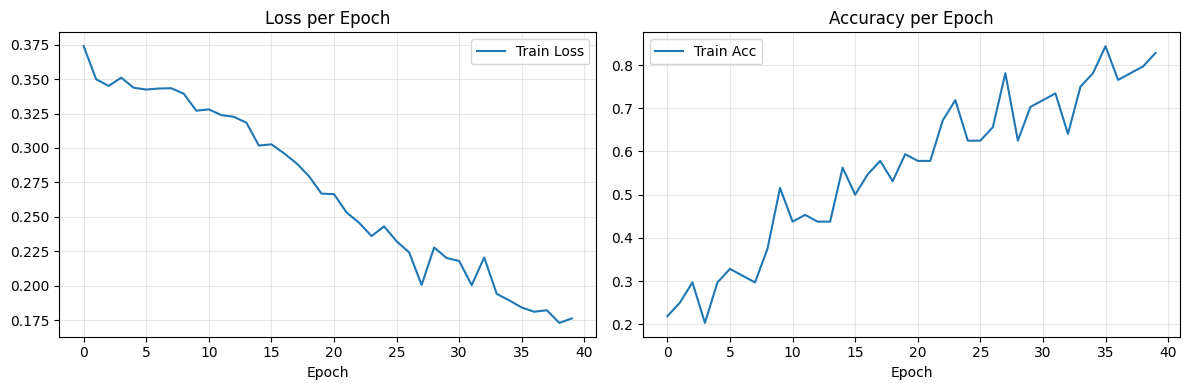


🌟 TRAINING COMPLETED
Model saved as 'best_cross_2dcnn_lstm_model.pth'

  CROSS-SUBJECT MODEL EVALUATION
Loading model from best_cross_2dcnn_lstm_model.pth
2D CNN + LSTM Net initialized:
  - LSTM input size: 7904
  - Sequence length: 371
  - Parameters: 1,028,260

--- Evaluating on test1 ---


c:\Users\marcd\Desktop\Master\Courses\Deep_Learning\Project_2\DL_2\Utils\utilities_Cross_NoVal.py:372: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(to

test1 - Accuracy: 0.6875 (68.8%), Loss: 0.4356, Samples: 16

--- Evaluating on test2 ---
test2 - Accuracy: 0.6875 (68.8%), Loss: 0.3796, Samples: 16

--- Evaluating on test3 ---
test3 - Accuracy: 0.4375 (43.8%), Loss: 0.4507, Samples: 16

--- OVERALL RESULTS ---
Individual test accuracies: ['0.688', '0.688', '0.438']
Mean accuracy: 0.6042 ± 0.1179
Weighted average accuracy: 0.6042
Total test samples: 48


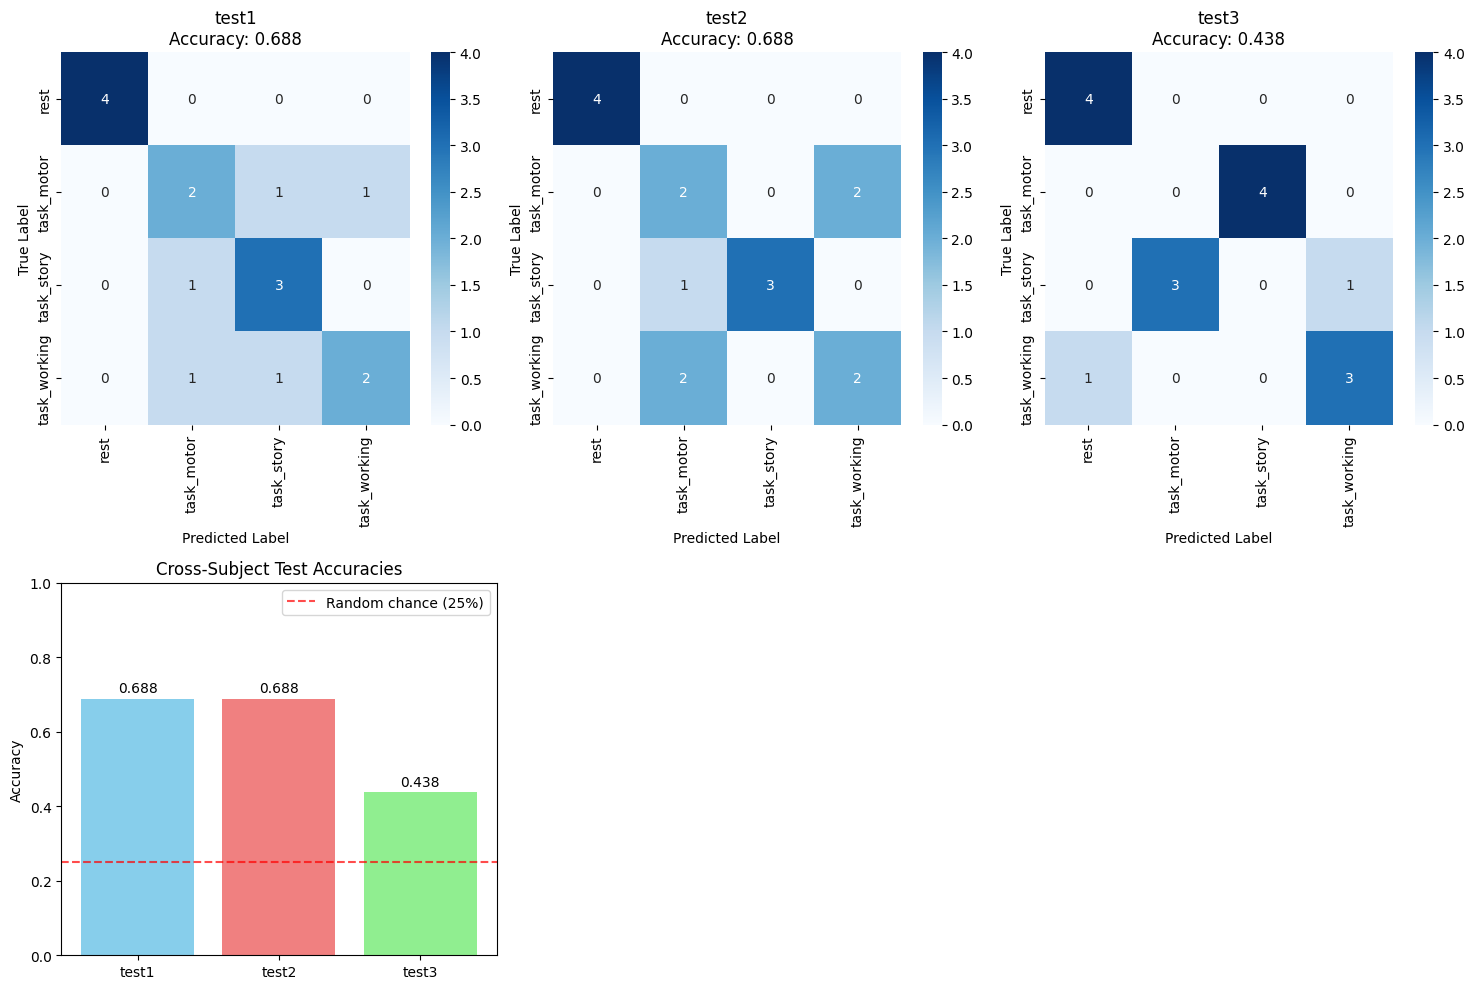


--- DETAILED CLASSIFICATION REPORTS ---

TEST1:
              precision    recall  f1-score   support

        rest      1.000     1.000     1.000         4
  task_motor      0.500     0.500     0.500         4
  task_story      0.600     0.750     0.667         4
task_working      0.667     0.500     0.571         4

    accuracy                          0.688        16
   macro avg      0.692     0.688     0.685        16
weighted avg      0.692     0.688     0.685        16


TEST2:
              precision    recall  f1-score   support

        rest      1.000     1.000     1.000         4
  task_motor      0.400     0.500     0.444         4
  task_story      1.000     0.750     0.857         4
task_working      0.500     0.500     0.500         4

    accuracy                          0.688        16
   macro avg      0.725     0.688     0.700        16
weighted avg      0.725     0.688     0.700        16


TEST3:
              precision    recall  f1-score   support

        re

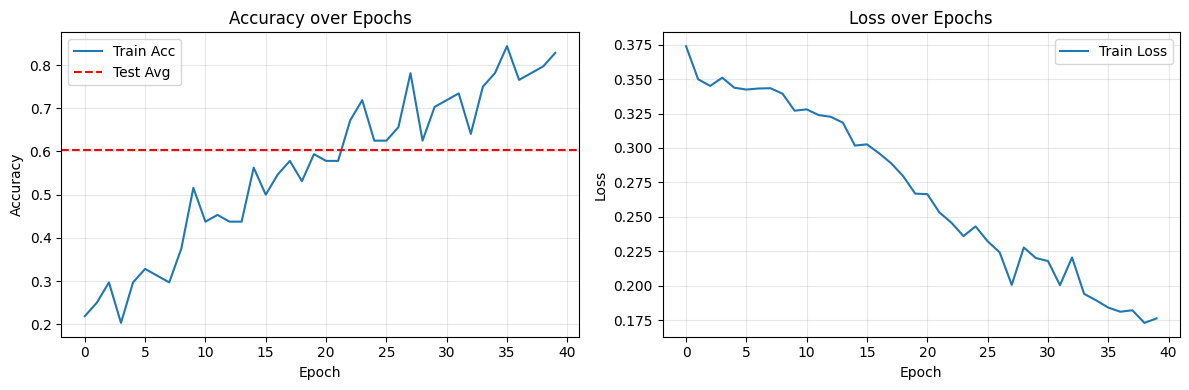

In [9]:
model, losses, accs, test_results = run_complete_cross_subject_experiment(
    filepath=filepath,
    model_fn=CNN2D_LSTM_Net_fn,
    label_map=LABEL_MAP,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    epochs=CONFIG["epochs"],
    file_batch_size=CONFIG["file_batch_size"],
    dataloader_batch_size=CONFIG["dataloader_batch_size"],
    downsample_factor=CONFIG["downsample_factor"],
    lr=CONFIG["lr"],               
    weight_decay=CONFIG["weight_decay"],
)